In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr


C:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
preprocessed_file = smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined_data.csv"
sitrep_df = pd.read_csv(preprocessed_file)
sitrep_df = sitrep_df.loc[sitrep_df["START_YEAR"]>2005].reset_index(drop=True)

incident_file = smart_nlp_path+r"input data\summary_reports_cleaned.csv"
incident_summary_df = pd.read_csv(incident_file)
incident_summary_df = incident_summary_df.drop("Unnamed: 0", axis=1)
incident_summary_df = incident_summary_df.loc[incident_summary_df["START_YEAR"]>=2006].reset_index(drop=True)

fire_ids = incident_summary_df['INCIDENT_ID'].unique()
sitrep_ids = sitrep_df['INCIDENT_ID'].unique()
sitrep_df = sitrep_df[sitrep_df['INCIDENT_ID'].isin(fire_ids)].reset_index(drop=True)
incident_summary_df =incident_summary_df[incident_summary_df['INCIDENT_ID'].isin(sitrep_ids)].reset_index(drop=True)
display(sitrep_df)
display(incident_summary_df)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (7,13,18,19,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text,Unique IDs
0,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010,5.000000,230.000000,197,196,"['resource', 'share', 'cactus']",2000_CA-RRU-062485_VALLEY COMPLEX_0
1,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,5.000000,230.000000,197,196,"['resource', 'share', 'incident', 'cactus', 'i...",2000_CA-RRU-062485_VALLEY COMPLEX_1
2,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010,4.000000,165.000000,197,196,"['resource', 'share', 'cactus', 'erratic', 'wi...",2000_CA-RRU-062485_VALLEY COMPLEX_2
3,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",2000_CA-RRU-062485_VALLEY COMPLEX_4
4,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",2000_CA-RRU-062485_VALLEY COMPLEX_5
...,...,...,...,...,...,...,...,...,...,...,...
44358,2014,3/15/2014 14:30,2014_VAVAS1403037_BEAVER LODGE RD.,100.0,2014,0.000000,13.000000,74,74,"['fast', 'spread', 'field']",2014_VAVAS1403037_BEAVER LODGE RD._0
44359,2014,3/19/2014 14:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,85.0,2014,0.000000,18.500000,80,78,"['heavy', 'plume', 'primary', 'carrier']",2014_VAVAS1406037_AIRPORT MOUNTAIN_1
44360,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014,1.000000,95.000000,234,232,"['heavy', 'canyon', 'river', 'mainly', 'canyon...",2014_WA-WFS-513_SAND RIDGE_0
44361,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014,1.000000,120.000000,235,232,"['laid', 'night', 'test', 'wind', 'remain', 'c...",2014_WA-WFS-513_SAND RIDGE_1


,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,EXPECTED_CONTAINMENT_DATE,...,FOD_CAUSE_DESCR,FOD_FIRE_SIZE,FOD_COMPLEX_NAME,FOD_OBJ,FOD_LIST,FOD_ID,MTBS_ID,MTBS_FIRE_NAME,FOD_LATITUDE,FOD_LONGITUDE
0,2000_CA-RRU-062485_VALLEY COMPLEX,CA-RRU-062485,VALLEY COMPLEX,WF,1312.0,L,True,2010-07-15 15:00:00,196,2010-07-18 00:00:00,...,Lightning,1289.0,VALLEY COMPLEX,"[{""ID"" : 1386075, ""COORDS"" : (33.63888888, -11...","['{""ID"" : 1386075, ""COORDS"" : (33.63888888, -1...",1432504.0,(VALLEY COMPLEX),NaN,34.066667,-87.189444
1,2005_OK-CHA-005077_WILLIS,OK-CHA-005077,WILLIS,WF,460.0,H,False,2005-12-30 00:00:00,1,2006-01-05 16:00:00,...,['Arson' 'Missing/Undefined'],920.0,NaN,"[{""ID"" : 251856, ""COORDS"" : (33.8833, -96.8169...","['{""ID"" : 251856, ""COORDS"" : (33.8833, -96.816...",251856.0,NaN,NaN,34.066667,-87.189444
2,2006_00276_MILLER COMPLEX,00276,MILLER COMPLEX,WF,300.0,L,True,2006-06-26 19:55:00,177,2006-07-03 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006_1224_MULTIPLE JUNE FIRES,1224,MULTIPLE JUNE FIRES,WF,21.0,L,False,2006-06-26 15:00:00,177,2006-07-01 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006_AK-DAS-612166_JARVIS CREEK,AK-DAS-612166,JARVIS CREEK,WF,275.0,H,False,2006-06-08 11:13:00,159,2006-06-13 23:59:00,...,Miscellaneous,275.0,NaN,"[{""ID"" : 311918, ""COORDS"" : (63.8667, -145.75)...","['{""ID"" : 311918, ""COORDS"" : (63.8667, -145.75...",311918.0,NaN,NaN,63.866700,-145.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,2014_VAS1400656_SANDY RIDGE,VAS1400656,Sandy Ridge,WF,600.0,H,False,2014-04-20 17:00:00,110,NaN,...,Equipment Use,449.0,NaN,"[{""ID"" : 300083747, ""COORDS"" : (37.01936111, -...","['{""ID"" : 300083747, ""COORDS"" : (37.01936111, ...",300083747.0,NaN,NaN,37.019361,-82.108083
8987,2014_VAS1406056_HUNTERS VALLEY WEST,VAS1406056,Hunters Valley West,WF,80.0,H,False,2014-04-19 08:00:00,109,NaN,...,Debris Burning,80.0,NaN,"[{""ID"" : 300001324, ""COORDS"" : (36.80361111, -...","['{""ID"" : 300001324, ""COORDS"" : (36.80361111, ...",300001324.0,NaN,NaN,36.803611,-82.635833
8988,2014_VAVAS1403037_BEAVER LODGE RD.,VAVAS1403037,Beaver Lodge Rd.,WF,0.0,H,False,2014-03-15 14:30:00,74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8989,2014_VAVAS1406037_AIRPORT MOUNTAIN,VAVAS1406037,Airport Mountain,WF,200.0,H,False,2014-03-19 14:00:00,78,NaN,...,Arson,375.0,NaN,"[{""ID"" : 300117756, ""COORDS"" : (37.24325, -82....","['{""ID"" : 300117756, ""COORDS"" : (37.24325, -82...",300117756.0,NaN,NaN,37.243250,-82.103528


## FIRE TREND ANALYSIS
examining trends in frequency, acres burned, and the number of days a fire burns on average per year. Potentially add FSR (WF_MAX_FSR), number of complexes (COMPLEX), evacuations (EVACUATION_REPORTED)


In [4]:
fire_trends_cols = ["FINAL_ACRES", "FOD_DISCOVERY_DOY", "FOD_CONTAIN_DOY", "START_YEAR"]
fire_trends_df = incident_summary_df[fire_trends_cols]
#fire_trends_df 

In [5]:
counts = fire_trends_df["START_YEAR"].value_counts()

In [6]:
years = []
count = []
for key in counts.index:
    years.append(key)
years.sort()
count = [counts[year] for year in years]

While the above plot does not show a consistent linear trend, these results are consistent with the findings of the authors of the original papers

In [7]:
years =  fire_trends_df["START_YEAR"].unique()
years.sort()

In [8]:
average_days_burning = {}
total_days_burning = {}
for year in years:
    list_of_days_burning = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        start_day = temp_df.iloc[i]['FOD_DISCOVERY_DOY']
        end_day = temp_df.iloc[i]["FOD_CONTAIN_DOY"]
        if not pd.isna(start_day) and not pd.isna(end_day):
            days_burn = end_day - start_day
            list_of_days_burning.append(days_burn)
    average_days_burning[year] = np.average(list_of_days_burning)
    total_days_burning[year] = np.sum(list_of_days_burning)
#print(total_days_burning)

In [9]:
total_acres = {}
average_acres = {}
for year in years:
    list_of_acres = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        acres = temp_df.iloc[i]['FINAL_ACRES']
        if not pd.isna(acres):
            list_of_acres.append(acres)
    average_acres[year] = np.average(list_of_acres)
    total_acres[year] = np.sum(list_of_acres)

#### Graphs

In [10]:
av_acres = [average_acres[key] for key in average_acres]
av_days_burn = [average_days_burning[key] for key in average_days_burning]
freq_scaled = minmax_scale(count)
av_days_burn_scaled = minmax_scale(av_days_burn)
av_acres_scaled = minmax_scale(av_acres)

total_days_burn = [total_days_burning[key] for key in total_days_burning]
total_acre = [total_acres[key] for key in total_acres]
total_days_burn_scaled = minmax_scale(total_days_burn)
total_acres_scaled = minmax_scale(total_acre)

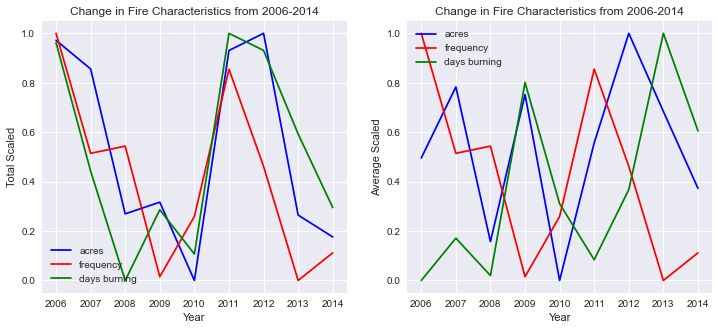

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, total_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, total_days_burn_scaled, color="green", label="days burning")
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, av_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, av_days_burn_scaled, color="green", label="days burning")
plt.legend()
plt.show()
plt.close()

## OPERATIONAL TRENDS ANALYSIS

operational trends are examined as aerial assets (total and max in one day), personnel (total and max in one day), and projected cost.
potentially add number of sit reports (INC_MGMT_NUM_SITREPS)??

In [12]:
operational_trends_cols = ["TOTAL_AERIAL_SUM", "TOTAL_PERSONNEL_SUM", "WF_PEAK_AERIAL", "WF_PEAK_PERSONNEL", "START_YEAR","PROJECTED_FINAL_IM_COST"]
operational_trends_df = incident_summary_df[operational_trends_cols]
#operational_trends_df 

In [13]:
total_aerial = {}
average_aerial = {}
total_person = {}
average_person = {}
for year in years:
    list_of_person = []
    list_of_aerial = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        aerial = temp_df.iloc[i]["WF_PEAK_AERIAL"]
        person = temp_df.iloc[i]['WF_PEAK_PERSONNEL']
        list_of_person.append(person)
        if pd.isna(aerial):
            aerial = 0
        list_of_aerial.append(aerial)
    average_aerial[year] = np.average(list_of_aerial)
    total_aerial[year] = np.sum(list_of_aerial)
    average_person[year] = np.average(list_of_person)
    total_person[year] = np.sum(list_of_person)
    
av_aerial = [average_aerial[key] for key in average_aerial]
total_aerial = [total_aerial[key] for key in total_aerial]

av_person = [average_person[key] for key in average_person]
total_person = [total_person[key] for key in total_person]

In [14]:
total_cost = {}
average_cost = {}
for year in years:
    list_of_cost = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        cost = temp_df.iloc[i]["PROJECTED_FINAL_IM_COST"]
        if not pd.isna(cost):
            list_of_cost.append(cost)
    average_cost[year] = np.average(list_of_cost)
    total_cost[year] = np.sum(list_of_cost)

av_cost = [average_cost[key] for key in average_cost]
total_cost = [total_cost[key] for key in total_cost]

#### Graphs

In [15]:
av_cost_scaled = minmax_scale(av_cost)
av_person_scaled = minmax_scale(av_person)
av_aerial_scaled = minmax_scale(av_aerial)

total_cost_scaled = minmax_scale(total_cost)
total_person_scaled = minmax_scale(total_person)
total_aerial_scaled = minmax_scale(total_aerial)

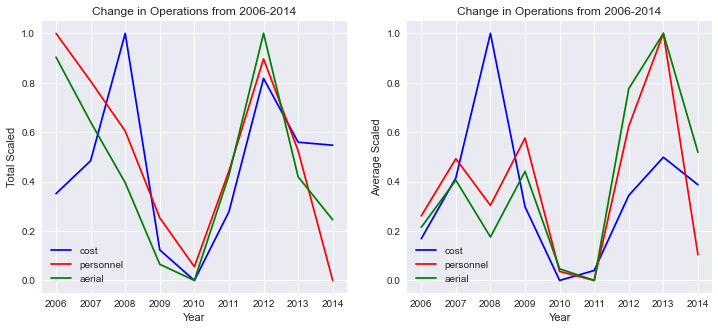

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, total_cost_scaled, color="blue", label="cost")
plt.plot(years, total_person_scaled, color="red", label="personnel")
plt.plot(years, total_aerial_scaled, color="green", label="aerial")
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, av_cost_scaled, color="blue", label="cost")
plt.plot(years, av_person_scaled, color="red", label="personnel")
plt.plot(years, av_aerial_scaled, color="green", label="aerial")
plt.legend()
plt.show()
plt.close()

## INTENSITY TREND ANALYSIS
intensity is looked at as the number of injuries, number of fatalities, number of structures damaged, number of structures destroyed

In [17]:
intensity_cols = ["STR_DESTROYED_TOTAL","STR_DAMAGED_TOTAL","INJURIES_TOTAL","FATALITIES", "START_YEAR"]
intensity_df = incident_summary_df[intensity_cols]
#intensity_df

In [18]:
total_str_des = {}
average_str_des = {}
total_str_damage = {}
average_str_damage = {}
total_injuries = {}
average_injuries = {}
total_fatalities = {}
average_fatalities = {}

for year in years:
    list_of_dest = []
    list_of_dam = []
    list_of_injury = []
    list_of_fatalities = []
    temp_df =intensity_df.loc[intensity_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        dest = temp_df.iloc[i]["STR_DESTROYED_TOTAL"]
        damage = temp_df.iloc[i]["STR_DAMAGED_TOTAL"]
        injury = temp_df.iloc[i]["INJURIES_TOTAL"]
        fatality = temp_df.iloc[i]["FATALITIES"]
        list_of_dest.append(dest)
        list_of_dam.append(damage)
        list_of_injury.append(injury)
        list_of_fatalities.append(fatality)
    total_str_des[year] = np.sum(list_of_dest)
    average_str_des[year] = np.average(list_of_dest)
    total_str_damage[year] = np.sum(list_of_dam)
    average_str_damage[year] = np.average(list_of_dam)
    total_injuries[year] = np.sum(list_of_injury)
    average_injuries[year] = np.average(list_of_injury)
    total_fatalities[year] = np.sum(list_of_fatalities)
    average_fatalities[year] = np.average(list_of_fatalities)

In [19]:
av_des = [average_str_des[key] for key in average_str_des]

total_des = [total_str_des[key] for key in total_str_des]

av_damage = [average_str_damage[key] for key in average_str_damage]

total_damage = [total_str_damage[key] for key in total_str_damage]

In [20]:
av_injury = [average_injuries[key] for key in average_injuries]
total_injury = [total_injuries[key] for key in total_injuries]
av_fatality = [average_fatalities[key] for key in average_fatalities]
total_fatality = [total_fatalities[key] for key in total_fatalities]

#### Graphs

In [21]:
total_fatality_scaled = minmax_scale(total_fatality)
total_injury_scaled = minmax_scale(total_injury)
total_damage_scaled = minmax_scale(total_damage)
total_des_scaled = minmax_scale(total_des)

av_fatality_scaled = minmax_scale(av_fatality)
av_injury_scaled = minmax_scale(av_injury)
av_damage_scaled = minmax_scale(av_damage)
av_des_scaled = minmax_scale(av_des)

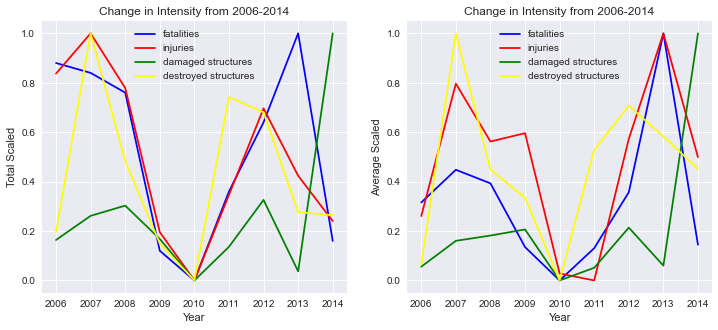

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, total_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, total_injury_scaled, color="red", label="injuries")
plt.plot(years, total_damage_scaled, color="green", label="damaged structures")
plt.plot(years, total_des_scaled, color="yellow", label="destroyed structures")
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, av_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, av_injury_scaled, color="red", label="injuries")
plt.plot(years, av_damage_scaled, color="green", label="damaged structures")
plt.plot(years, av_des_scaled, color="yellow", label="destroyed structures")
plt.legend()
plt.show()
plt.close()

## Correlation Matrix

In [23]:
totals = {"Fire Frequency": count,
    "total Days Fires Burned": total_days_burn,
    "total Acres Fires Burned": total_acre,
    "total Aerial Assets": total_aerial,
    "total Personnel": total_person,
    "total Cost": total_cost,
    "total Structures Damaged": total_damage,
    "total Structures Destroyed": total_des,
    "total Injuries": total_injury,
    "total Fatalities": total_fatality}
totals_df = pd.DataFrame(totals)

averages = {
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality}
avs_df = pd.DataFrame(averages)

totals_scaled = {feature:minmax_scale(totals[feature]) for feature in totals}

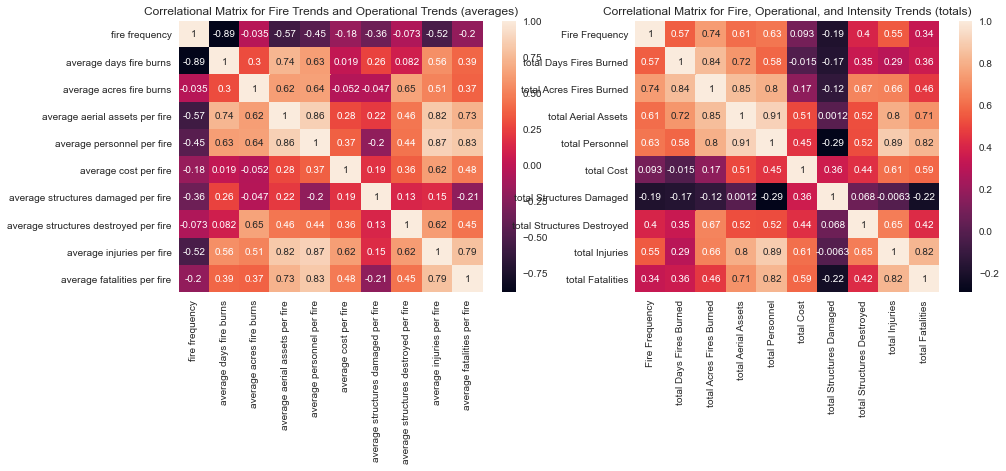

In [24]:
corrMatrix_avs = avs_df.corr()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sn.heatmap(corrMatrix_avs, annot=True)
plt.title("Correlational Matrix for Fire Trends and Operational Trends (averages)")

plt.subplot(1, 2, 2)
corrMatrix_totals = totals_df.corr()
sn.heatmap(corrMatrix_totals, annot=True)
plt.title("Correlational Matrix for Fire, Operational, and Intensity Trends (totals)")
plt.show()

As seen above, fire frequency is negatively correlated with assets, indicating higher frequencies may be smaller fires, where lower frequencies are related to larger fires, thus more assets. 

The average days the fire burns is weakly correlated with max assets, would likely be closer correlated with total assets accross an operation. Negatively correlated with fire frequency, indication longer fires occur less frequently.

average acres burned is moderately positively correlated with assets, but for some reason is negatively correlated with days burning (could be due to outliers)

average maximum aerial assets is strongest correlated with personnel, which makes sense. Also positively correlated with acres burned, days burning, and cost, indicating more aerial support is needed in more intense fires.

average maximum personnel is positively correlated with acres burned and days burning

cost is most strongly associated with days burning, assets, and personnel, but it is still moderate. Cost can likely be explained better by number of structures damages

In [25]:
lines = {"Fire Frequency": '--',
    "total Days Fires Burned": '--',
    "total Acres Fires Burned": '--',
    "total Aerial Assets": '-',
    "total Personnel": '-',
    "total Cost": '-',
    "total Structures Damaged": ':',
    "total Structures Destroyed": ':',
    "total Injuries": ':',
    "total Fatalities": ':'}
colors = cm.tab10(np.linspace(0, 1, len(lines)))
colors_dict = {}
i = 0
for feature in lines:
    colors_dict[feature] = colors[i]
    i+=1
markers = {"Fire Frequency": '.',
    "total Days Fires Burned": 'v',
    "total Acres Fires Burned": '^',
    "total Aerial Assets": 's',
    "total Personnel": 'p',
    "total Cost": 'P',
    "total Structures Damaged": 'h',
    "total Structures Destroyed": 'X',
    "total Injuries": 'D',
    "total Fatalities": '*'}

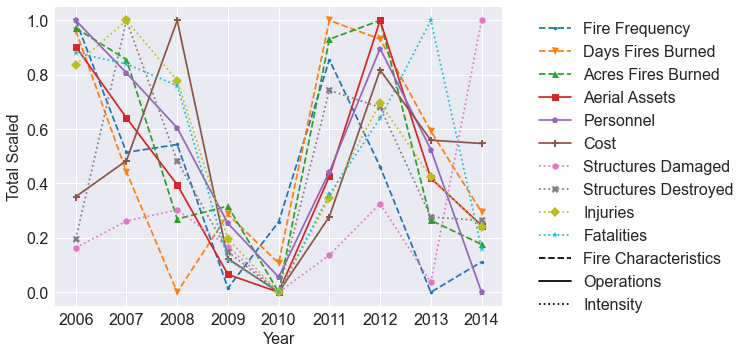

In [26]:
plt.figure()
plt.ylabel("Total Scaled", fontsize=16)
plt.xlabel("Year", fontsize=16)
#plt.title("Fire, Operations, and Intensity Trends from 2006-2014")
#years = [year.strip(".") for year in years]
for feature in totals_scaled:
    plt.plot(years, totals_scaled[feature], label=feature.replace("total ",""), linestyle=lines[feature], marker=markers[feature], color=colors_dict[feature])
    plt.tick_params(labelsize=16)
plt.plot([],[], label='Fire Characteristics', color='black', linestyle='--')
plt.plot([],[], label = 'Operations', color='black', linestyle = '-')
plt.plot([],[], label = 'Intensity', color = 'black', linestyle = ':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.show()

## HAZARD METRIC ANALYSIS

In [27]:
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
list_of_attributes = ["Combined Text"]
file = smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined_data.csv"

ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
ICS.extract_preprocessed_data(file)

Preprocessed data extracted from:  C:\Users\srandrad\smart_nlp\/\input data\ICS_filtered_preprocessed_combined_data.csv


In [28]:
preprocessed_df = ICS.data_df
hazard_file = smart_nlp_path+r"\output data\hazard_interpretation_v2.xlsx"

In [29]:
preprocessed_df

,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text,Unique IDs
0,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010,5.000000,230.000000,197,196,"[resource, share, cactus]",2000_CA-RRU-062485_VALLEY COMPLEX_0
1,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,5.000000,230.000000,197,196,"[resource, share, incident, cactus, incident, ...",2000_CA-RRU-062485_VALLEY COMPLEX_1
2,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010,4.000000,165.000000,197,196,"[resource, share, cactus, erratic, wind, due, ...",2000_CA-RRU-062485_VALLEY COMPLEX_2
3,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010,4.333333,192.333333,197,196,"[resource, share, cactus, cactus, become, vall...",2000_CA-RRU-062485_VALLEY COMPLEX_4
4,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,4.333333,192.333333,197,196,"[resource, share, cactus, cactus, become, vall...",2000_CA-RRU-062485_VALLEY COMPLEX_5
...,...,...,...,...,...,...,...,...,...,...,...
44358,2014,3/15/2014 14:30,2014_VAVAS1403037_BEAVER LODGE RD.,100.0,2014,0.000000,13.000000,74,74,"[fast, spread, field]",2014_VAVAS1403037_BEAVER LODGE RD._0
44359,2014,3/19/2014 14:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,85.0,2014,0.000000,18.500000,80,78,"[heavy, plume, primary, carrier]",2014_VAVAS1406037_AIRPORT MOUNTAIN_1
44360,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014,1.000000,95.000000,234,232,"[heavy, canyon, river, mainly, canyon, come, e...",2014_WA-WFS-513_SAND RIDGE_0
44361,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014,1.000000,120.000000,235,232,"[laid, night, test, wind, remain, canyon, peri...",2014_WA-WFS-513_SAND RIDGE_1


In [30]:
time_of_occurence_days, time_of_occurence_pct_contained, frequency, fires, frequency_fires, categories, hazards, years, ids = calc_metrics(hazard_file, preprocessed_df, rm_outliers=True)

C:\Users\srandrad\Anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:41<00:00, 31.23s/it]


### Hazards, metrics, primary results table

In [31]:
table_data = create_primary_results_table(time_of_occurence_days, time_of_occurence_pct_contained, frequency, frequency_fires, preprocessed_df, categories, hazards, years, interval=False)
display(pd.DataFrame(table_data))

,Hazard Category,Hazard Name,OTTO days,OTTO %,Average Occurrences per year,Average fires per occurrence,Total Frequency,Total Fire Frequency
0,Mission,Traffic,9.831+-10.889,45.399+-35.27,128.111,7.798,3896,1153
1,Mission,Command Transitions,15.95+-21.251,64.612+-36.433,135.111,7.394,2882,1216
2,Mission,Evacuations,11.109+-12.66,38.31+-32.025,115.556,8.645,3395,1040
3,Mission,Inaccurate Mapping,6.201+-6.422,68.63+-32.711,71.889,13.896,827,647
4,Mission,Aerial Grounding,16.086+-17.537,28.106+-30.373,13.889,71.928,219,125
5,Mission,Resource Issues,10.546+-12.107,35.531+-33.546,92.667,10.781,2218,834
6,Mission,Injuries,9.901+-10.425,58.098+-33.323,61.222,16.318,902,551
7,Wildland Urban Interface,Cultural Resources,8.534+-8.306,49.153+-35.295,22.333,44.731,861,201
8,Wildland Urban Interface,Livestock,8.421+-9.204,35.592+-32.514,30.889,32.342,728,278
9,Wildland Urban Interface,Law Violations,2.128+-6.797,98.367+-11.634,21.111,47.321,196,190


In [32]:
severity_total, severity_table = calc_severity(fires, incident_summary_df)
severity_table

,Hazard,Average Severity,std dev Severity,n total,n after outliers,formatted
0,Traffic,1.597,2.190,1153,975,1.597+-2.19
1,Command Transitions,2.111,2.733,1216,1045,2.111+-2.733
2,Evacuations,2.860,3.864,1040,884,2.86+-3.864
3,Inaccurate Mapping,1.493,2.260,647,556,1.493+-2.26
4,Aerial Grounding,3.239,4.162,125,109,3.239+-4.162
5,Resource Issues,1.979,2.840,834,724,1.979+-2.84
6,Injuries,4.215,4.439,551,478,4.215+-4.439
7,Cultural Resources,3.406,4.367,201,180,3.406+-4.367
8,Livestock,2.547,3.357,278,245,2.547+-3.357
9,Law Violations,1.047,0.791,190,172,1.047+-0.791


In [51]:
severity_accross_all_incidents = []
for i in range(len(incident_summary_df)):
    severity = int(incident_summary_df.iloc[i]["STR_DESTROYED_TOTAL"]) + int(incident_summary_df.iloc[i]["STR_DAMAGED_TOTAL"])+ int(incident_summary_df.iloc[i]["INJURIES_TOTAL"])+ int(incident_summary_df.iloc[i]["FATALITIES"])
    severity_accross_all_incidents.append(severity)
print(len(severity_accross_all_incidents))
severity_accross_all_incidents = remove_outliers(severity_accross_all_incidents)
print(len(severity_accross_all_incidents))
print(str(round(np.average(severity_accross_all_incidents),3))+"+-"+str(round(np.std(severity_accross_all_incidents),3)))

8991
7665
0.322+-0.616


### Metrics Time Series
frequency and OTTO in pct containment

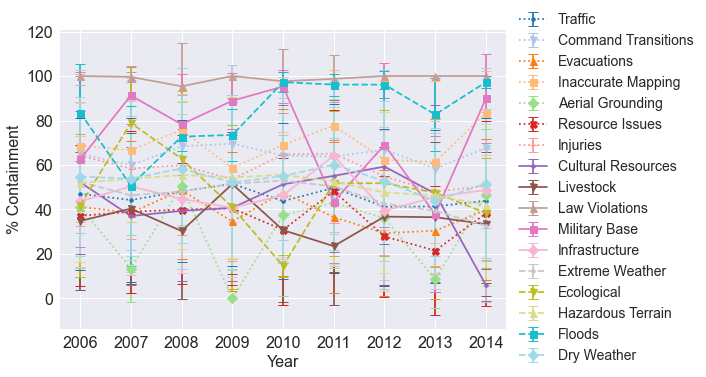

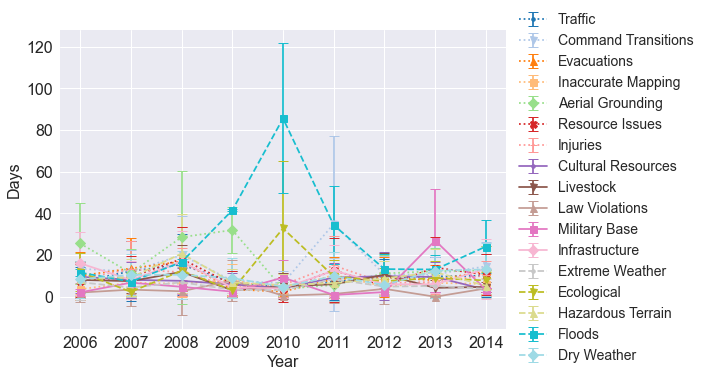

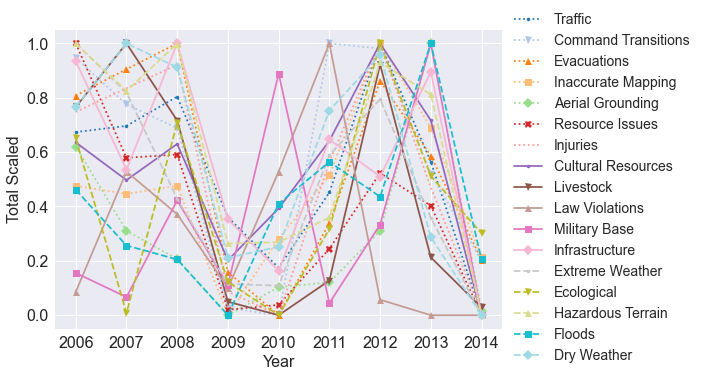

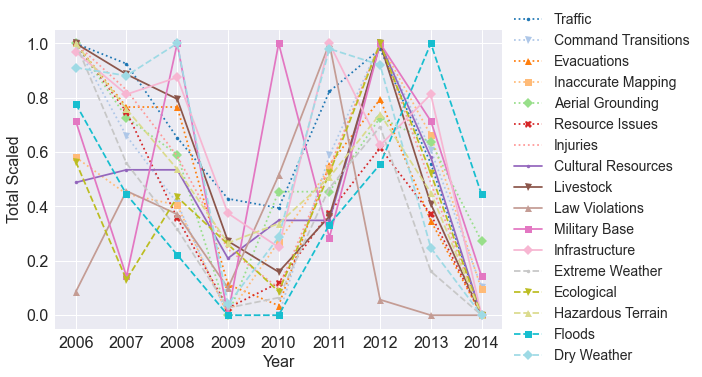

In [33]:
days_averages, days_stddevs, pct_averages, pct_stddevs, frequencies, hazard_freqs_scaled, frequencies_fire, fire_freqs_scaled = create_metrics_time_series(time_of_occurence_days, time_of_occurence_pct_contained, frequency, frequency_fires, years, categories, combined=True)

### Correlation Matrix

In [34]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(totals_scaled, fire_freqs_scaled, graph=False)

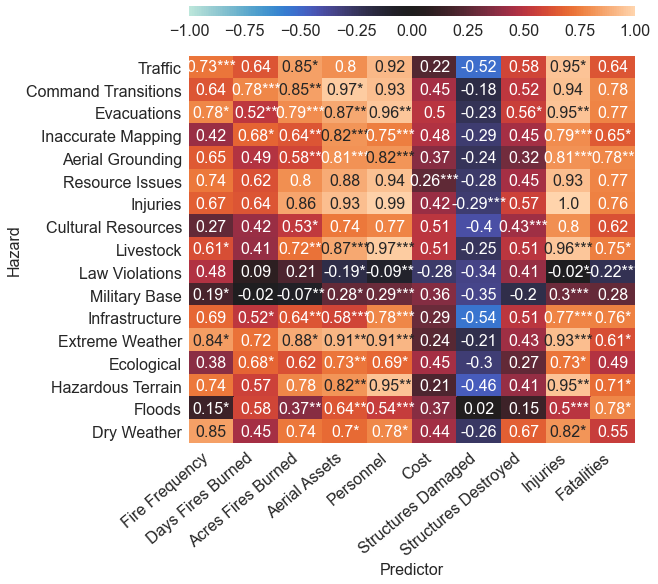

In [35]:
predictors = [p for p in totals_scaled]
hazards = ["total "+h for h in fire_freqs_scaled]
reshape_correlation_matrix(corrMatrix_fires, p_values, predictors, hazards)

# Multiple regression
typically multiple regression is used as a prediction algorithm, given a certain set of continuous inputs X=(x1,2,...xn), what is the value of continuous variable y? Multiple regression uses a linear combination of X to produce y, and the error in y/goodness of fit indicates how good the predictors are.

The importance of a predictor, xi, is evaluated by shuffling its input values, and seeing how the goodness of fit/error changes.

### Our goal: 
use regression to determine what the most important predictors are for the frequency of hazards. Since we have a limited number of data points (9) we will not be predicting on unseen data.

#### Inputs/Predictors: 
All operations trends, fire characteristics, and intensity
#### Output/y: 
annual frequency of hazards time series
#### Method:
for each hazard, use its frequency time series:
1. fit linear regression model to the X,y
2. calculate correlation coefficient
For each Xi:
3. Randomly shuffle the input values
4. Have the full model predict the y value
5. record correlation coefficient
5. record (orignal coefficient-shuffled xi coefficient) -> positive large delta means importance, negative delta indicates it should be removed, small delta means little importance

Future goal: use ML to determine whether or not a hazard will occur based on past incident reports

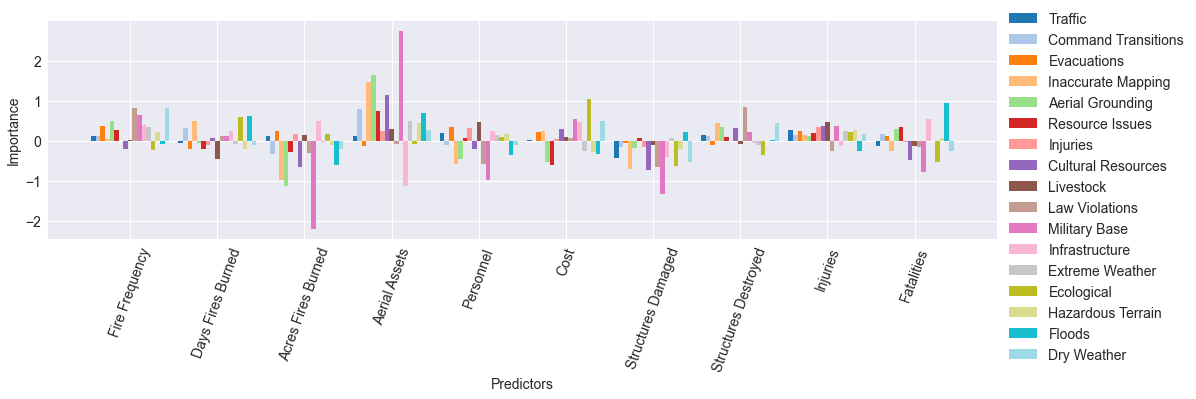

,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,...,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Structures Damaged removed MSE,total Structures Destroyed removed MSE,total Injuries removed MSE,total Fatalities removed MSE
0,total Traffic,1.0,0.0,0.963,0.987,0.934,0.942,0.890,0.999,0.675,...,0.004,0.001,0.006,0.006,0.011,0.000,0.032,0.002,0.025,0.003
1,total Command Transitions,1.0,0.0,0.969,0.639,0.704,-0.441,0.978,1.000,0.973,...,0.004,0.048,0.040,0.193,0.003,0.000,0.004,0.001,0.007,0.008
2,total Evacuations,1.0,0.0,0.712,0.871,0.784,0.958,0.725,0.885,0.998,...,0.036,0.016,0.027,0.005,0.034,0.014,0.000,0.001,0.018,0.004
3,total Inaccurate Mapping,1.0,0.0,0.993,-0.259,-3.516,-7.085,-0.073,0.778,-0.082,...,0.001,0.103,0.369,0.661,0.088,0.018,0.088,0.019,0.007,0.015
4,total Aerial Grounding,1.0,0.0,0.110,0.987,-5.593,-9.913,0.272,0.021,0.927,...,0.066,0.001,0.492,0.814,0.054,0.073,0.005,0.012,0.005,0.025
5,total Resource Issues,1.0,0.0,0.781,0.838,0.729,-0.676,0.980,0.095,0.987,...,0.022,0.016,0.027,0.169,0.002,0.091,0.001,0.001,0.014,0.032
6,total Injuries,1.0,0.0,1.000,0.970,0.908,0.841,0.775,0.994,0.968,...,0.000,0.004,0.011,0.019,0.027,0.001,0.004,0.000,0.036,0.000
7,total Cultural Resources,1.0,0.0,0.848,0.959,-1.307,-4.836,0.842,0.631,-0.387,...,0.010,0.003,0.158,0.400,0.011,0.025,0.095,0.010,0.041,0.055
8,total Livestock,1.0,0.0,0.998,0.357,0.919,0.795,0.530,0.983,0.984,...,0.000,0.083,0.010,0.027,0.061,0.002,0.002,0.001,0.071,0.004
9,total Law Violations,1.0,0.0,-0.808,0.920,0.629,0.985,0.143,0.987,0.233,...,0.179,0.008,0.037,0.002,0.085,0.001,0.076,0.070,0.018,0.006


,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,...,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Structures Damaged removed MSE,total Structures Destroyed removed MSE,total Injuries removed MSE,total Fatalities removed MSE
0,total Traffic,1.0,0.0,0.037,0.013,0.066,0.058,0.110,0.001,0.325,...,-0.004,-0.001,-0.006,-0.006,-0.011,-0.000,-0.032,-0.002,-0.025,-0.003
1,total Command Transitions,1.0,0.0,0.031,0.361,0.296,1.441,0.022,0.000,0.027,...,-0.004,-0.048,-0.040,-0.193,-0.003,-0.000,-0.004,-0.001,-0.007,-0.008
2,total Evacuations,1.0,0.0,0.288,0.129,0.216,0.042,0.275,0.115,0.002,...,-0.036,-0.016,-0.027,-0.005,-0.034,-0.014,-0.000,-0.001,-0.018,-0.004
3,total Inaccurate Mapping,1.0,0.0,0.007,1.259,4.516,8.085,1.073,0.222,1.082,...,-0.001,-0.103,-0.369,-0.661,-0.088,-0.018,-0.088,-0.019,-0.007,-0.015
4,total Aerial Grounding,1.0,0.0,0.890,0.013,6.593,10.913,0.728,0.979,0.073,...,-0.066,-0.001,-0.492,-0.814,-0.054,-0.073,-0.005,-0.012,-0.005,-0.025
5,total Resource Issues,1.0,0.0,0.219,0.162,0.271,1.676,0.020,0.905,0.013,...,-0.022,-0.016,-0.027,-0.169,-0.002,-0.091,-0.001,-0.001,-0.014,-0.032
6,total Injuries,1.0,0.0,0.000,0.030,0.092,0.159,0.225,0.006,0.032,...,-0.000,-0.004,-0.011,-0.019,-0.027,-0.001,-0.004,-0.000,-0.036,-0.000
7,total Cultural Resources,1.0,0.0,0.152,0.041,2.307,5.836,0.158,0.369,1.387,...,-0.010,-0.003,-0.158,-0.400,-0.011,-0.025,-0.095,-0.010,-0.041,-0.055
8,total Livestock,1.0,0.0,0.002,0.643,0.081,0.205,0.470,0.017,0.016,...,-0.000,-0.083,-0.010,-0.027,-0.061,-0.002,-0.002,-0.001,-0.071,-0.004
9,total Law Violations,1.0,0.0,1.808,0.080,0.371,0.015,0.857,0.013,0.767,...,-0.179,-0.008,-0.037,-0.002,-0.085,-0.001,-0.076,-0.070,-0.018,-0.006


In [36]:
predictors = [p for p in totals_scaled]
hazards = [h.replace("total ","") for h in fire_freqs_scaled]
results_df, delta_df = multiple_reg_feature_importance(predictors, hazards, correlation_mat_total_fires)
display(results_df, delta_df)

In [37]:
cols = [col for col in delta_df.columns if "MSE" in col]
delta_df.drop(cols, axis=1)

,hazard,R2 for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,total Structures Destroyed removed score,total Injuries removed score,total Fatalities removed score
0,total Traffic,1.0,0.037,0.013,0.066,0.058,0.110,0.001,0.325,0.024,0.255,0.035
1,total Command Transitions,1.0,0.031,0.361,0.296,1.441,0.022,0.000,0.027,0.010,0.054,0.061
2,total Evacuations,1.0,0.288,0.129,0.216,0.042,0.275,0.115,0.002,0.006,0.143,0.032
3,total Inaccurate Mapping,1.0,0.007,1.259,4.516,8.085,1.073,0.222,1.082,0.236,0.089,0.183
4,total Aerial Grounding,1.0,0.890,0.013,6.593,10.913,0.728,0.979,0.073,0.160,0.061,0.331
5,total Resource Issues,1.0,0.219,0.162,0.271,1.676,0.020,0.905,0.013,0.012,0.138,0.315
6,total Injuries,1.0,0.000,0.030,0.092,0.159,0.225,0.006,0.032,0.000,0.298,0.001
7,total Cultural Resources,1.0,0.152,0.041,2.307,5.836,0.158,0.369,1.387,0.143,0.598,0.801
8,total Livestock,1.0,0.002,0.643,0.081,0.205,0.470,0.017,0.016,0.005,0.551,0.034
9,total Law Violations,1.0,1.808,0.080,0.371,0.015,0.857,0.013,0.767,0.709,0.187,0.059


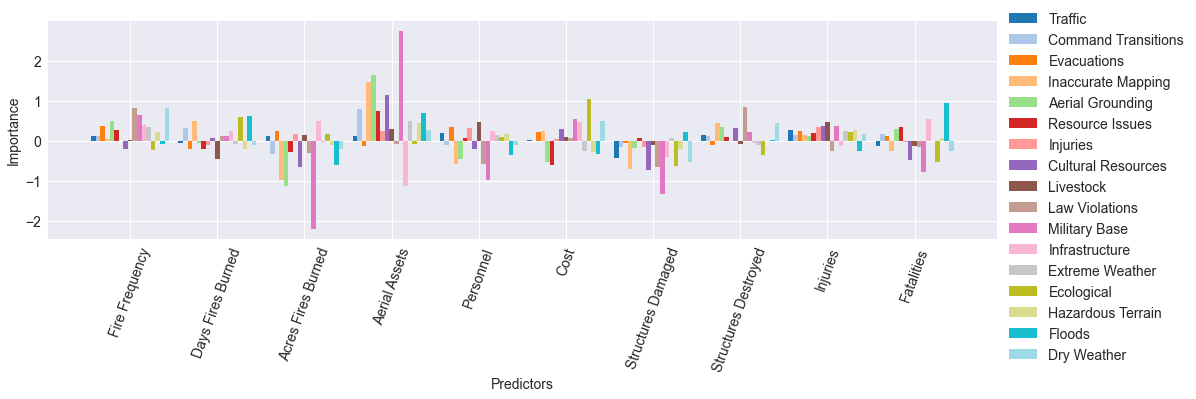

,hazard,R2 for full model,Fire Frequency score,total Days Fires Burned score,total Acres Fires Burned score,total Aerial Assets score,total Personnel score,total Cost score,total Structures Damaged score,total Structures Destroyed score,total Injuries score,total Fatalities score
0,total Traffic,1.0,0.531,0.412,0.730,0.633,0.843,0.047,0.266,0.337,0.898,0.413
1,total Command Transitions,1.0,0.415,0.610,0.716,0.935,0.860,0.198,0.034,0.266,0.887,0.615
2,total Evacuations,1.0,0.613,0.272,0.627,0.751,0.913,0.252,0.052,0.319,0.911,0.591
3,total Inaccurate Mapping,1.0,0.178,0.462,0.416,0.672,0.556,0.226,0.086,0.206,0.620,0.423
4,total Aerial Grounding,1.0,0.422,0.236,0.334,0.658,0.671,0.136,0.058,0.100,0.656,0.610
5,total Resource Issues,1.0,0.543,0.378,0.639,0.772,0.880,0.065,0.078,0.204,0.870,0.586
6,total Injuries,1.0,0.447,0.410,0.732,0.864,0.981,0.179,0.087,0.320,1.000,0.582
7,total Cultural Resources,1.0,0.075,0.175,0.281,0.540,0.591,0.261,0.162,0.188,0.633,0.388
8,total Livestock,1.0,0.375,0.172,0.522,0.750,0.937,0.264,0.063,0.263,0.924,0.564
9,total Law Violations,1.0,0.233,0.009,0.043,0.034,0.009,0.077,0.117,0.171,0.000,0.047


In [38]:
results_df = regression_feature_importance(predictors, hazards, correlation_mat_total_fires)
cols = [col for col in results_df.columns if "MSE" in col]
results_df.drop(cols, axis=1)

# experimental

In [39]:
totals_new = {predictor: totals_scaled[predictor] for predictor in totals_scaled if predictor not in ["total Structures Damaged", "total Structures Destroyed"]}
totals_new["total structure"] = minmax_scale([totals["total Structures Damaged"][i]+totals["total Structures Destroyed"][i] for i in range(len(totals["total Structures Destroyed"]))])

In [40]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(totals_new, fire_freqs_scaled, graph=False)

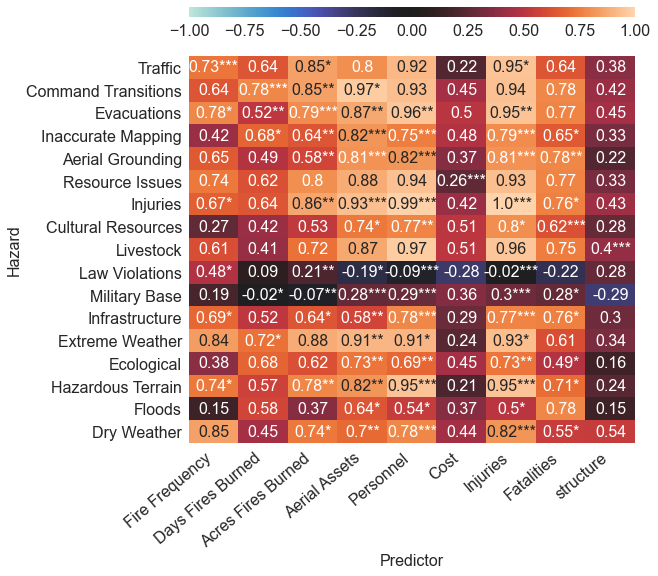

In [41]:
predictors = [p for p in totals_new]
hazards = ["total "+h for h in fire_freqs_scaled]
reshape_correlation_matrix(corrMatrix_fires, p_values, predictors, hazards)

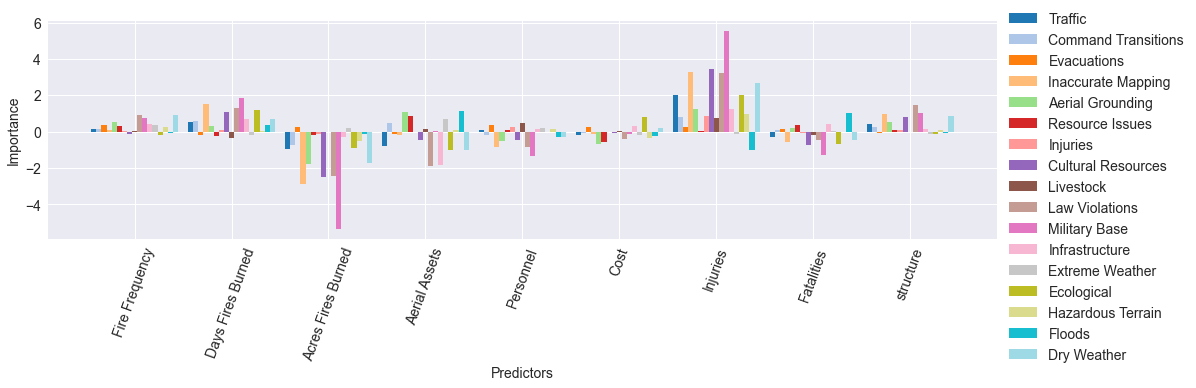

,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Injuries removed score,...,total structure removed score,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Injuries removed MSE,total Fatalities removed MSE,total structure removed MSE
0,total Traffic,1.0,0.0,0.936,-0.164,-2.476,-0.852,0.989,0.885,-11.602,...,0.795,0.006,0.114,0.340,0.181,0.001,0.011,1.234,0.021,0.020
1,total Command Transitions,1.0,0.0,0.962,0.007,-0.558,0.553,0.949,0.989,-0.548,...,0.957,0.005,0.133,0.209,0.060,0.007,0.001,0.208,0.003,0.006
2,total Evacuations,1.0,0.0,0.711,0.880,0.804,0.951,0.726,0.887,0.834,...,0.992,0.036,0.015,0.024,0.006,0.034,0.014,0.021,0.004,0.001
3,total Inaccurate Mapping,1.0,0.0,0.958,-11.130,-39.033,0.890,-1.216,0.933,-39.129,...,-0.214,0.003,0.992,3.273,0.009,0.181,0.005,3.280,0.077,0.099
4,total Aerial Grounding,1.0,0.0,0.024,0.432,-15.891,-3.566,-0.046,-0.581,-5.086,...,0.564,0.073,0.042,1.260,0.341,0.078,0.118,0.454,0.011,0.032
5,total Resource Issues,1.0,0.0,0.786,0.737,0.894,-1.076,0.975,0.159,0.991,...,0.989,0.022,0.027,0.011,0.210,0.003,0.085,0.001,0.035,0.001
6,total Injuries,1.0,0.0,0.999,0.978,0.927,0.999,0.828,0.999,-0.874,...,0.995,0.000,0.003,0.009,0.000,0.021,0.000,0.226,0.001,0.001
7,total Cultural Resources,1.0,0.0,0.932,-6.374,-34.885,0.074,0.229,0.971,-50.740,...,-0.023,0.005,0.505,2.458,0.063,0.053,0.002,3.544,0.149,0.070
8,total Livestock,1.0,0.0,0.997,0.598,1.000,0.949,0.571,0.994,-0.370,...,0.998,0.000,0.052,0.000,0.007,0.056,0.001,0.177,0.007,0.000
9,total Law Violations,1.0,0.0,-1.154,-6.138,-22.621,-10.140,-0.931,0.610,-31.279,...,-1.308,0.213,0.705,2.334,1.101,0.191,0.039,3.189,0.062,0.228


,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Injuries removed score,...,total structure removed score,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Injuries removed MSE,total Fatalities removed MSE,total structure removed MSE
0,total Traffic,1.0,0.0,0.064,1.164,3.476,1.852,0.011,0.115,12.602,...,0.205,-0.006,-0.114,-0.340,-0.181,-0.001,-0.011,-1.234,-0.021,-0.020
1,total Command Transitions,1.0,0.0,0.038,0.993,1.558,0.447,0.051,0.011,1.548,...,0.043,-0.005,-0.133,-0.209,-0.060,-0.007,-0.001,-0.208,-0.003,-0.006
2,total Evacuations,1.0,0.0,0.289,0.120,0.196,0.049,0.274,0.113,0.166,...,0.008,-0.036,-0.015,-0.024,-0.006,-0.034,-0.014,-0.021,-0.004,-0.001
3,total Inaccurate Mapping,1.0,0.0,0.042,12.130,40.033,0.110,2.216,0.067,40.129,...,1.214,-0.003,-0.992,-3.273,-0.009,-0.181,-0.005,-3.280,-0.077,-0.099
4,total Aerial Grounding,1.0,0.0,0.976,0.568,16.891,4.566,1.046,1.581,6.086,...,0.436,-0.073,-0.042,-1.260,-0.341,-0.078,-0.118,-0.454,-0.011,-0.032
5,total Resource Issues,1.0,0.0,0.214,0.263,0.106,2.076,0.025,0.841,0.009,...,0.011,-0.022,-0.027,-0.011,-0.210,-0.003,-0.085,-0.001,-0.035,-0.001
6,total Injuries,1.0,0.0,0.001,0.022,0.073,0.001,0.172,0.001,1.874,...,0.005,-0.000,-0.003,-0.009,-0.000,-0.021,-0.000,-0.226,-0.001,-0.001
7,total Cultural Resources,1.0,0.0,0.068,7.374,35.885,0.926,0.771,0.029,51.740,...,1.023,-0.005,-0.505,-2.458,-0.063,-0.053,-0.002,-3.544,-0.149,-0.070
8,total Livestock,1.0,0.0,0.003,0.402,0.000,0.051,0.429,0.006,1.370,...,0.002,-0.000,-0.052,-0.000,-0.007,-0.056,-0.001,-0.177,-0.007,-0.000
9,total Law Violations,1.0,0.0,2.154,7.138,23.621,11.140,1.931,0.390,32.279,...,2.308,-0.213,-0.705,-2.334,-1.101,-0.191,-0.039,-3.189,-0.062,-0.228


In [42]:
predictors = [p for p in totals_new]
hazards = [h.replace("total ","") for h in fire_freqs_scaled]
results_df, delta_df = multiple_reg_feature_importance(predictors, hazards, correlation_mat_total_fires)
display(results_df, delta_df)

# Colinearity

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\srandrad\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [44]:
vif_data = pd.DataFrame()
input_df = pd.DataFrame({predictor:totals_new[predictor] for predictor in totals_new})
vif_data["feature"] = input_df.columns
vif_data["VIF"] = [variance_inflation_factor(input_df.values, i)
                          for i in range(len(input_df.columns))]
vif_data

,feature,VIF
0,Fire Frequency,9.372532
1,total Days Fires Burned,84.862083
2,total Acres Fires Burned,332.177775
3,total Aerial Assets,43.545142
4,total Personnel,227.285517
5,total Cost,22.377706
6,total Injuries,153.619137
7,total Fatalities,74.813929
8,total structure,56.605611


In [45]:
sums = []
for col in input_df:
    temp_input = input_df.drop(col, axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = temp_input.columns
    vif_data["VIF"] = [variance_inflation_factor(temp_input.values, i)
                          for i in range(len(temp_input.columns))]
    sum_vif = sum(vif_data["VIF"].tolist())
    sums.append(sum_vif)
    display(col,sum_vif, vif_data)
print(min(sums), sums.index(min(sums)), predictors[sums.index(min(sums))])

'Fire Frequency'

874.2608395842219

,feature,VIF
0,total Days Fires Burned,82.824391
1,total Acres Fires Burned,301.584569
2,total Aerial Assets,36.501202
3,total Personnel,205.447455
4,total Cost,19.391711
5,total Injuries,112.816456
6,total Fatalities,73.685879
7,total structure,42.009178


'total Days Fires Burned'

538.035783209351

,feature,VIF
0,Fire Frequency,9.147481
1,total Acres Fires Burned,132.865089
2,total Aerial Assets,38.693173
3,total Personnel,182.196690
4,total Cost,19.212424
5,total Injuries,86.212397
6,total Fatalities,17.671910
7,total structure,52.036619


'total Acres Fires Burned'

379.0700298560391

,feature,VIF
0,Fire Frequency,8.509332
1,total Days Fires Burned,33.943295
2,total Aerial Assets,43.162600
3,total Personnel,81.677140
4,total Cost,9.770322
5,total Injuries,149.917677
6,total Fatalities,30.142188
7,total structure,21.947476


'total Aerial Assets'

906.2918007677797

,feature,VIF
0,Fire Frequency,7.856415
1,total Days Fires Burned,75.406421
2,total Acres Fires Burned,329.259607
3,total Personnel,226.443716
4,total Cost,18.502834
5,total Injuries,128.647223
6,total Fatalities,69.120223
7,total structure,51.055361


'total Personnel'

460.89062434248405

,feature,VIF
0,Fire Frequency,8.472000
1,total Days Fires Burned,68.027171
2,total Acres Fires Burned,119.371137
3,total Aerial Assets,43.383863
4,total Cost,14.576626
5,total Injuries,142.466755
6,total Fatalities,47.569723
7,total structure,17.023349


'total Cost'

648.6538121925981

,feature,VIF
0,Fire Frequency,8.121897
1,total Days Fires Burned,72.858508
2,total Acres Fires Burned,145.032021
3,total Aerial Assets,36.004965
4,total Personnel,148.051637
5,total Injuries,152.419784
6,total Fatalities,66.587901
7,total structure,19.577098


'total Injuries'

747.9856123416431

,feature,VIF
0,Fire Frequency,6.883100
1,total Days Fires Burned,47.625340
2,total Acres Fires Burned,324.173936
3,total Aerial Assets,36.466561
4,total Personnel,210.785133
5,total Cost,22.202997
6,total Fatalities,52.860827
7,total structure,46.987720


'total Fatalities'

525.7731317094015

,feature,VIF
0,Fire Frequency,9.231213
1,total Days Fires Burned,20.045399
2,total Acres Fires Burned,133.832896
3,total Aerial Assets,40.231144
4,total Personnel,144.517328
5,total Cost,19.917207
6,total Injuries,108.541747
7,total structure,49.456198


'total structure'

522.0122406859819

,feature,VIF
0,Fire Frequency,6.955713
1,total Days Fires Burned,78.012336
2,total Acres Fires Burned,128.794014
3,total Aerial Assets,39.275487
4,total Personnel,68.352953
5,total Cost,7.739349
6,total Injuries,127.517624
7,total Fatalities,65.364765


379.0700298560391 2 total Acres Fires Burned


In [46]:
to_drop = ["total Acres Fires Burned", "total Personnel", "total Injuries", "total Aerial Assets", "total Cost"]#,"total Days Fires Burned"]
temp_input = input_df.drop(to_drop, axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = temp_input.columns
vif_data["VIF"] = [variance_inflation_factor(temp_input.values, i)
                      for i in range(len(temp_input.columns))]
sum_vif = sum(vif_data["VIF"].tolist())
display(sum_vif, vif_data)

15.375449095878839

,feature,VIF
0,Fire Frequency,3.945490
1,total Days Fires Burned,4.428526
2,total Fatalities,3.620239
3,total structure,3.381193
